## Data Loader

In [8]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def create_train_val_test_dataloaders(data_dir, batch_size, num_workers=4):
    # Define specific transformations for each dataset
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((244, 244)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
        'valid': transforms.Compose([
            transforms.Resize((244, 244)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
    }

    # Create datasets using specific transformations
    image_datasets = {
        'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']),
        'valid': datasets.ImageFolder(os.path.join(data_dir, 'valid'), data_transforms['valid']),
    }

    # Create dataloaders
    dataloaders = {
        'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
        'valid': DataLoader(image_datasets['valid'], batch_size=batch_size, shuffle=False, num_workers=num_workers),
    }

    return dataloaders

### Switching to GPU Utilization Mood

In [9]:
import torch
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Code to save figures

In [10]:
# code to save the figures as high-res PNGs
import os
from pathlib import Path
from matplotlib import pyplot as plt

IMAGES_PATH = Path() / "Images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Load Model

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

def load_mobilenet_v3_large(num_classes):
    model = models.mobilenet_v3_large(weights='MobileNet_V3_Large_Weights.DEFAULT')
    num_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(num_features, num_classes)
    return model

### Model Training Section

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

class ModelTrainer:
    def __init__(self, model, dataloaders, criterion, optimizer, num_epochs, save_dir):
        self.model = model
        self.dataloaders = dataloaders
        self.criterion = criterion
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        
        # Lists to store loss and accuracy values
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def train(self):
        # Create directory for saving models if it doesn't exist
        os.makedirs(self.save_dir, exist_ok=True)

        train_loader = self.dataloaders['train']
        val_loader = self.dataloaders['valid']

        for epoch in range(self.num_epochs):
            # Training phase
            self.model.train()
            running_train_loss = 0.0
            correct_train = 0
            total_train = 0

            for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{self.num_epochs} - Training'):
                inputs, labels = inputs.to(device), labels.to(device)

                self.optimizer.zero_grad()

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()

                running_train_loss += loss.item() * inputs.size(0)

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                correct_train += (predicted == labels).sum().item()
                total_train += labels.size(0)

            train_loss = running_train_loss / len(train_loader.dataset)
            train_acc = correct_train / total_train

            # Validation phase
            self.model.eval()
            running_val_loss = 0.0
            correct_val = 0
            total_val = 0

            with torch.no_grad():
                for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{self.num_epochs} - Validation'):
                    inputs, labels = inputs.to(device), labels.to(device)

                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)

                    running_val_loss += loss.item() * inputs.size(0)

                    # Calculate accuracy
                    _, predicted = torch.max(outputs, 1) 
                    correct_val += (predicted == labels).sum().item()
                    total_val += labels.size(0)

            val_loss = running_val_loss / len(val_loader.dataset)
            val_acc = correct_val / total_val

            # Store loss and accuracy values
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)

            # Print epoch statistics
            print(f'Epoch [{epoch+1}/{self.num_epochs}] - '
                  f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%')

            # Save the model after each epoch
            torch.save(self.model.state_dict(), os.path.join(self.save_dir, f'model_epoch_{epoch+1}.pth'))

        print('Training complete.')

    def plot_learning_curves(self, fig_name):
        plt.figure(figsize=(12, 6))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(range(1, len(self.train_losses) + 1), self.train_losses, label='Train Loss')
        plt.plot(range(1, len(self.val_losses) + 1), self.val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Curve')
        plt.legend()

        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(range(1, len(self.train_accuracies) + 1), self.train_accuracies, label='Train Accuracy')
        plt.plot(range(1, len(self.val_accuracies) + 1), self.val_accuracies, label='Val Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy Curve')
        plt.legend()

        plt.tight_layout()
        plt.savefig(fig_name)
        plt.show()

### Train: Mobilenet_v3_large

In [13]:
import os

train_dir = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
classes = [folder for folder in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, folder))]

# Count the number of classes
num_classes = len(classes)

print(f"Number of classes: {num_classes}")

Number of classes: 38


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 130MB/s] 
Epoch 1/10 - Validation: 100%|██████████| 550/550 [00:45<00:00, 12.03it/s]


Epoch [1/10] - Train Loss: 0.1628, Train Acc: 95.24%, Val Loss: 0.1348, Val Acc: 96.36%


Epoch 2/10 - Validation: 100%|██████████| 550/550 [00:31<00:00, 17.31it/s]


Epoch [2/10] - Train Loss: 0.0711, Train Acc: 97.87%, Val Loss: 0.0929, Val Acc: 97.34%


Epoch 3/10 - Validation: 100%|██████████| 550/550 [00:30<00:00, 17.79it/s]


Epoch [3/10] - Train Loss: 0.0601, Train Acc: 98.23%, Val Loss: 0.1066, Val Acc: 96.83%


Epoch 4/10 - Validation: 100%|██████████| 550/550 [00:30<00:00, 18.16it/s]


Epoch [4/10] - Train Loss: 0.0526, Train Acc: 98.46%, Val Loss: 0.0525, Val Acc: 98.47%


Epoch 5/10 - Validation: 100%|██████████| 550/550 [00:29<00:00, 18.50it/s]


Epoch [5/10] - Train Loss: 0.0471, Train Acc: 98.70%, Val Loss: 0.0839, Val Acc: 97.79%


Epoch 6/10 - Validation: 100%|██████████| 550/550 [00:30<00:00, 18.16it/s]


Epoch [6/10] - Train Loss: 0.0457, Train Acc: 98.76%, Val Loss: 0.0938, Val Acc: 97.60%


Epoch 7/10 - Validation: 100%|██████████| 550/550 [00:32<00:00, 16.85it/s]


Epoch [7/10] - Train Loss: 0.0389, Train Acc: 98.94%, Val Loss: 0.0404, Val Acc: 99.05%


Epoch 8/10 - Validation: 100%|██████████| 550/550 [00:30<00:00, 17.90it/s]


Epoch [8/10] - Train Loss: 0.0357, Train Acc: 99.04%, Val Loss: 0.0294, Val Acc: 99.32%


Epoch 9/10 - Validation: 100%|██████████| 550/550 [00:32<00:00, 17.18it/s]


Epoch [9/10] - Train Loss: 0.0360, Train Acc: 99.05%, Val Loss: 0.0422, Val Acc: 99.08%


Epoch 10/10 - Validation: 100%|██████████| 550/550 [00:30<00:00, 17.92it/s]


Epoch [10/10] - Train Loss: 0.0330, Train Acc: 99.14%, Val Loss: 0.0324, Val Acc: 99.17%
Training complete.


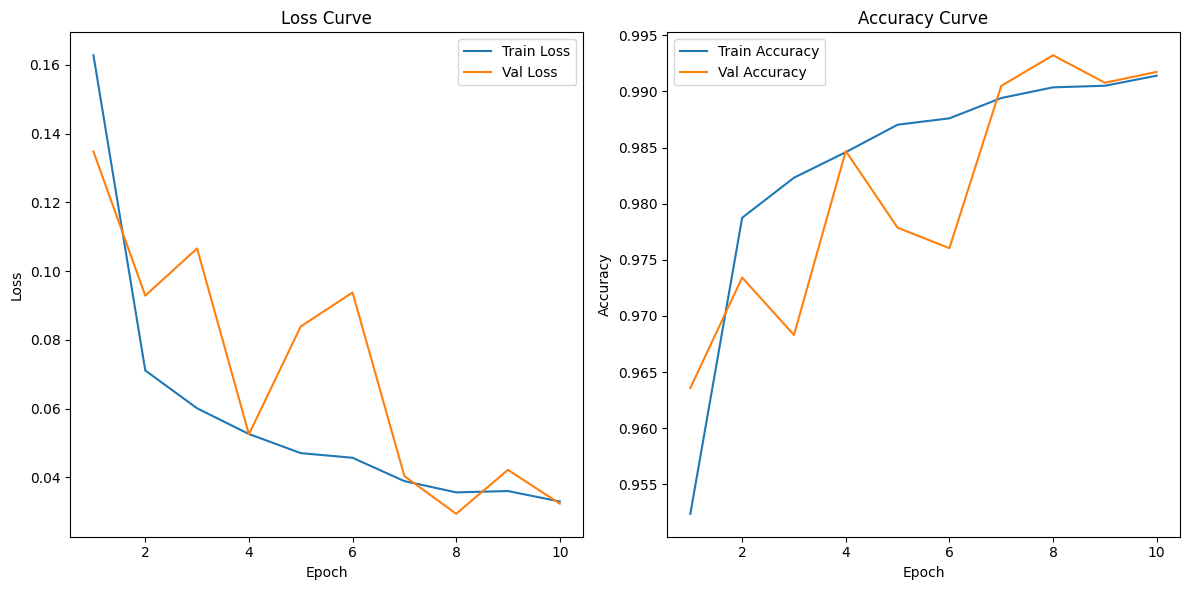

In [14]:
data_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
batch_size = 32
dataloaders = create_train_val_test_dataloaders(data_dir, batch_size)
model = load_mobilenet_v3_large(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create an instance of ModelTrainer
trainer = ModelTrainer(
    model=model,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,
    save_dir='Checkpoints/mobilenet_v3_large'
)

# Train the model
trainer.train()

# Plot learning curves
trainer.plot_learning_curves('learning_curves_mobilenet_v3_large')